# Modelo de Ising: Metropolis

En este notebook se describe el modelo de Ising por medio métodos Monte Carlo: Metropolis. Se busca dar descripción cuantitativa de un ferromagneto por medio de la simulación estocástica Metropolis. Con Metropolis-Montecarlo se busca evolucionar el sistema a un estado de equilibrio dada una temperatura $T$; mientras que con integración Montecarlo se pretende determinar varias cantidades observables del sistema tales como la magnetización y la energía (?).

## 1. Introducción...

## 2. Simulación

In [1]:
using PyPlot

using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/rogve98/.julia/conda/3/lib/python3.9/site-packages/numpy/__init__.py'>

### 2.1 Armado de la red y cálculo de la energía del sistema.

Se va a construir una red de $N\times N$ con $N^2$ número de átomos de la red. El primer paso para la simulación es generar una lista con los cuatro vecinos de cada sitio implementando condiciones de frontera periódicas. Quiere decir que cada sitio de la red $(i,j)$ va a tener cuatro vecinos (arriba, abajo, derecha e izquierda). 

Posteriormente, calculamos la energía de un par de configuraciones de spines y un valor de $J=0.5$ (Que se ha tomado como consenso en la clase). La energía individual está dada por

$$
E=-J\sum_{\langle ij\rangle}s_is_j
$$

con $s_i,s_j=\pm1$ dependiendo si la proyección de espín apunta hacia arriba o hacia abajo del eje de cuantización.

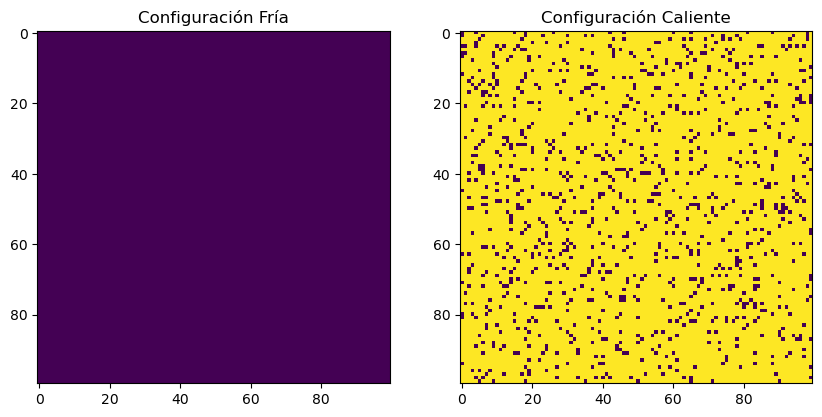

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/rogve98/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(0.5, 1.0, 'Configuración Caliente')

In [2]:
#Definimos una función que nos genere la red de spines con valores ∈{1,-1}
function redSpinesCaliente(N)
    red = ones(Int,N,N)
    for i in 1:N
        for j in 1:N
            if rand() <= 0.1
                red[i,j] = -1
            end
        end
    end
    return red
end
    
    
redSpinesFrio(N) = ones(Int,N,N)
redCaliente = redSpinesCaliente(100)
redFria = redSpinesFrio(100)

figure(figsize=(10,6))

subplot(1,2,1)
imshow(redFria)
title("Configuración Fría")

subplot(1,2,2)
imshow(redCaliente)
title("Configuración Caliente")


Queremos que nuestra red de espines la podamos expresar en un un arreglo 1-dimensional con la siguiente lógica

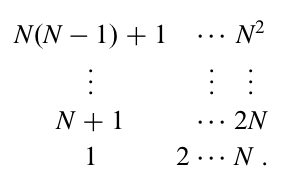

Para ello generamos una función que nos devuelva dicho arreglo con las entradas de los valores de la red de spines.

In [3]:
mutable struct MicroEstados
    σ::Array{Int,1} #Arreglo de spines aleatorios
    N::Int          #Arreglo de N×N de spines
    frio::Array{Int,1} #Arreglo de spines alineados
end

In [4]:
"""
La función devuelve un vector con las entradas de la matriz de espines

N := longitud del arreglo cuadrado de N×N

"""
function Lista(N::Int)
    matriz = redSpinesCaliente(N)
    lista = []
    for i in 1:N
        for j in 1:N
            push!(lista,matriz[i,j])
        end
    end
    
    frio = ones(N^2)
    
    MicroEstados(lista,N,frio)
end

Lista

In [5]:
microEstados = Lista(1000)
microEstados.frio

1000000-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [6]:
"""
Generamos la lista de los primeros vecinos para un sitio (i,j) en la matriz y para
un sitio i del vector generado por la función Lista. La lista vendrá en la siguiente
configuración [arriba,derecha,abajo,izquierda]

Parámetros:

m := Microestado que guarda la información de la red 
     de spines de N×N y la longitud N.
i := sitio al que nos queremos enfocar

"""
function vecinos(m::MicroEstados,i::Int)
    N² = (m.N)^2
    N = m.N
    
    #Para el vecino de arriba
    if i <= N²
        arriba = i + N
        if arriba > N²
            arriba = i - N*(N-1)
        end
    end
    
    #Para el vecino de la derecha
    if mod(i,N) != 0
        derecha = i + 1
    else
        derecha = i - N + 1
    end
    
    #Para el vecino de abajo
    if i - N >= 1
        abajo = i - N
    else i - N < 1
        abajo = i + N*(N-1)
    end  
    
    #Para el vecino de la izquierda
    if mod(i-1,N) != 0
        izquierda = i - 1
    else
        izquierda = i + N - 1
    end
    
    #Regresa los índices, recuerda
    return [m.σ[arriba],m.σ[derecha],m.σ[abajo],m.σ[izquierda]],
           [m.frio[arriba],m.frio[derecha],m.frio[abajo],m.frio[izquierda]]
end

vecinos

In [7]:
vecinos(microEstados,1)

([1, 1, 1, 1], [1, 1, 1, 1])

La energía para dados dos átomos en interacción esta dada por la siguiente expresión desarrollada

$$
\Delta E_{ij}=-2J\sigma_{i,j}(\sigma_{i+1,j}+\sigma_{i-1},j+\sigma_{i,j+1}+\sigma_{i,j-1})-2h\sigma_{i,j}
$$

sin embargo, el último término de la igualadad anterior no lo consideraremos porque no se van a considerar campos externos al sistema de interés (ferromagneto)

In [8]:
"""
Ahora generamos la energía de interacción entre átomos dada por
E = -J⋅∑s_is_j

Parámetros:

m := Micro Estado con configuracion caliente y fria
i := sitio

"""
function energia_i(m::MicroEstados,i::Int)
    J = 0.5 #se escogió este valor por consenso en clase
    σi = m.σ[i]
    frio = m.frio[i]
    
    vecinosCaliente, vecinosFrio = vecinos(m,i)
    sumC = 0
    sumF = 0
    for i in 1:4
        sumC += vecinosCaliente[i]
        sumF += vecinosFrio[i]
    end
    return -2J*σi*sumC, -2J*frio*sumF
end   

function energiaTotal(m::MicroEstados)
    sumC = 0
    sumF = 0
    energias = []
    eCaliente = zeros(m.N^2)
    eFria = zeros(m.N^2)
    for i in 1:m.N^2
        push!(energias,energia_i(m,i))
        eCaliente[i] , eFria[i] = energias[i]
        #eCaliente[i] = energias[i]
        sumC += eCaliente[i]
        sumF += eFria[i]
    end
    
    return sumC,sumF #Por qué dividiamos entre dos?
end

energiaTotal (generic function with 1 method)

In [9]:
println(energia_i(microEstados,1))
println(energiaTotal(microEstados))

(-4.0, -4.0)
(-2.56148e6, -4.0e6)


### 2.2 Cálculo de la temperatura crítica

Para determinar la temperatura crítica en la que ocurre la transición de fase de ferromagneto a paramagneto, necesitamos determinar la solución de la siguiente ecuación trascendental

$$
2\tanh^2\left(\frac{2J}{K_BT_C}\right)=1
$$

Considerando que $K_B=1$ se encuentra en unidades naturales para que la ecuación tenga sentido. Para ello vamos a determinar la solución mediante el método de Newton-Rhapson.

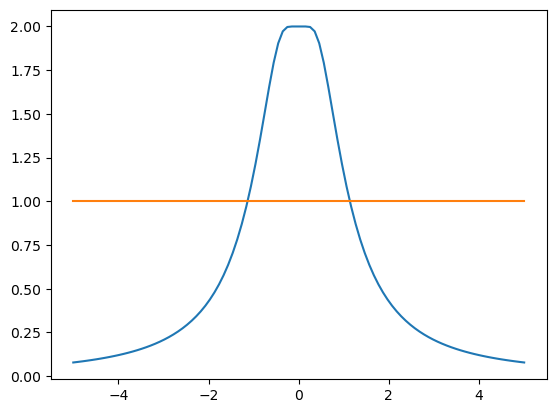

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3be3fa38e0>

In [10]:
xs = range(-5, stop = 5, length = 100)
ys = [2*tanh(1/T)^2 for T in xs]
ys1 = [1 for x in xs]
plot(xs,ys)
plot(xs,ys1)

In [4]:
#Igualando la ecuación trascendental a cero y quedándonos con el lado izquierdo
tempCritica(T) = 2*tanh(1/T)^2 - 1 

function Dcentrada(f,a,h)
    derivada = (f(a+h) - f(a-h))/2h
    return derivada
end

function newtonRhapson(f,x_inicial,epsilon,n)
    h=0.0001
    if n==1
        return x_inicial
    elseif n > 1
        iteracion = newtonRhapson(f,x_inicial,epsilon,n-1)-f(newtonRhapson(f,x_inicial,epsilon,n-1))/Dcentrada(f,newtonRhapson(f,x_inicial,epsilon,n-1),h)
    end
    return iteracion
end

newtonRhapson (generic function with 1 method)

In [6]:
raiz = newtonRhapson(tempCritica,2,0.1,10)

1.134592657106511

### 2.3 Evolución y termalización del sistema

En esta sección se abarcará la integración Montecarlo y la simulación con el algorítmo de Metropolis. La función de partición es la herramienta fundamental por la que se hallan las cantidades observables y la función de estado.

$$
Z = \sum_{C}e^{-\beta E(C)}
$$

donde $\beta=1K_BT$ y la suma corre sobre todas las posibles configuraciones posibles de los átomos de la red, sin embargo realizar cálculos es muy exhaustivo por lo que se requieren otro tipo de técnicas para poder resolver el problema. El algorítmo Metropolis Montecarlo "se centra en el cálculo de probabilidades de transición entre dos diferentes configuraciones (eliminando así la necesidad de la función de partición) y que tiene por objetivo generar  una colección de configuraciones de espines que obedezcan la distribución del ensamble canónico (del Ángel, 2022)"

In [37]:
"""
Generamos una función para voltear el spín; se va a utilizar para
pasar de una configuración C_j a una C_k después de cierto número de pasos.

Parámetros

m := MicroEstado
i := Sitio de la configuración de la lista de spines generada.

"""
volteaSpinC(m::MicroEstados,i::Int) = m.σ[i] *= -1 #De esta manera se voltean los ±1
volteaSpinF(m::MicroEstados,i::Int) = m.frio[i] *= -1

"""
Generamos una función para cambiar de Micro Estado, si estamos en uno C_j y queremos
cambiar a otro C_k, proponemos ese cambio en lugar de pasar por un número n de
micro estados, esperando que de esta manera C_j y C_k no estén correlacionados.

Parámetros

m := MicroEstado


"""
function eleccionDeMicroEstado(m::MicroEstados)
    i = rand(1:m.N)
    ΔEcaliente, ΔEfria = energia_i(m,i)
    
    return ΔEcaliente, ΔEfria, i
end

"""
Generamos el paso Metropolis-MonteCarlo que consiste en ubicarse en un Micro Estado
arbitrario para voltearle el spin y calcular su energía de interacción con sus vecinos.
El micro estado se acepta si cumple que el mínimo entre e^(-β*ΔE) y 1 es mayor a un 
número aleatorio entre 0 y 1. Las pruebas en la simulación se harán para una temperatura
fría y otra caliente.

Parámteros

m := MicroEstado
T := Temperatura
conf := configuración caliente o fria

"""

function Metropolis(m::MicroEstados,T::Float64,conf::String)
    aceptado = false
    β = 1/T
    while aceptado == false
        
        ΔEcaliente , ΔEfria, i = eleccionDeMicroEstado(m)
        if conf == "caliente"
            parametro = min(1.,exp(-β*ΔEcaliente))
            if rand() < parametro
                aceptado = true
                volteaSpinC(m,i)
                return ΔEcaliente
            end
        
        elseif conf == "fria"
            parametro = min(1.,exp(-β*ΔEfria))
            if rand() < parametro
                aceptado = true
                volteaSpinF(m,i)
                return ΔEfria
            end
        else
            return "Escoge entre caliente o fria"
        end
    end    
end

Metropolis (generic function with 1 method)

In [38]:
Metropolis(microEstados,0.5,"fria")

-4.0

#### 2.3.2 Simluación Monte-Carlo 

Se utilizará el algorítmo de selección: Metropolis para hacer una iteración de n pasos para poder ver las interacciones que presentan los átomos al voltearle el spín...

In [39]:
"""
Simulación montecarlo, es utilizar metropolis para un número n de pasos.

Parámetros

m := MicroEstados
T := Temperatura
n := número de pasos
conf := configuración caliente o fria


"""
function simulacionMontecarlo(m::MicroEstados,T,n::Int,conf::String)
    β = 1/T
    
    energiaCaliente = zeros(n)
    energiaFria = zeros(n)
    energiaCaliente[1] , energiaFria[1] = energiaTotal(m)
    

    if conf == "caliente"
        for i in 1:n-1 
            ΔE = Metropolis(m,β,conf) 
            energiaCaliente[i+1] = energiaCaliente[i] + ΔE
        end
        return energiaCaliente
   
    elseif conf == "fria"
        for i in 1:n-1
            ΔE = Metropolis(m,β,conf)
            energiaFria[i+1] = energiaCaliente[i] + ΔE
        end
        return energiaFria
    end
end

simulacionMontecarlo

In [40]:
microEstados = Lista(1000)
microEstados.N

1000

In [41]:
vecinos(microEstados,1)

([1, 1, 1, 1], [1, 1, 1, 1])

In [42]:
println(energia_i(microEstados,1))
println(energiaTotal(microEstados))

(-4.0, -4.0)
(-2.557744e6, -4.0e6)


In [43]:
enerFria = simulacionMontecarlo(microEstados,1.5,10000,"fria")
enerCaliente = simulacionMontecarlo(microEstados,1.5,10000,"caliente")

10000-element Vector{Float64}:
 -2.557744e6
 -2.557746e6
 -2.557748e6
 -2.557752e6
 -2.557756e6
 -2.557756e6
 -2.55776e6
 -2.557764e6
 -2.557766e6
 -2.55777e6
 -2.557772e6
 -2.557776e6
 -2.55778e6
  ⋮
 -2.559266e6
 -2.559266e6
 -2.559266e6
 -2.559266e6
 -2.559266e6
 -2.559266e6
 -2.559266e6
 -2.559266e6
 -2.559266e6
 -2.559266e6
 -2.559268e6
 -2.559268e6

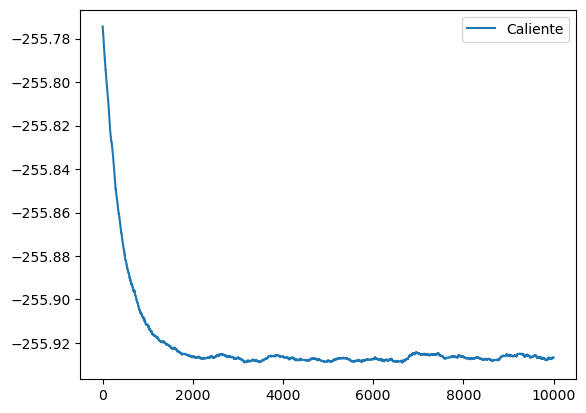

PyObject <matplotlib.legend.Legend object at 0x7f3be3e76a90>

In [44]:
#plot(enerFria/10000,label = "Fria")
plot(enerCaliente/10000, label = "Caliente")
legend()

### Opción de termalización

In [21]:
function Metropolis1(m::MicroEstados,T,n::Int,conf::String)
    β = 1/T
    energiaCaliente = zeros(n)
    energiaCaliente[1] = 0
    if conf == "caliente"
        for k in 1:n-1
          for i in 1:m.N^2
                ΔE = energia_i(m,i)
                if ΔE < 0 || rand() < exp(ΔE*β)
                    volteaSpinC(m,i)
                end
                energiaCaliente[i+1] = energiaCaliente[i] + ΔE
            end
        end
        return energiaCaliente
    end
end

Metropolis1 (generic function with 1 method)

In [25]:
#ener = Metropolis1(microEstados,0.5,1000000,"caliente")

In [23]:
#plot(ener)